<a href="https://colab.research.google.com/github/dssp-ethz/DSSP-Illustrations/blob/main/Wiener_Filter_Deblurring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deblurring an image

Assume you changed career and became a photographer. You have taken an amazing photo of your friend. You want to send her the photograph, but you are afraid to fall victim of a man-in-the-middle attack. You surely do not want somebody else to claim your photo, so remembering your course on DSSP you apply a filter to deblur the image and you add some (white) gaussian noise, just to be sure. You call your friend to hear her opinion on the photograph. Although your friend recognizes the potential of the image she sounds upset that it is all blurry and noisy. Help her to recover her photo and gain her grace!

The data model is
$$Y = h * X + W$$
where $X$ is the original image, $h$ is the applied (2D) filter and $W$ the white noise producing the deblurred image $Y$. First, decide on a filter and the amount of white noise introduced:

In [1]:
import ipywidgets as widgets

import parser
import numpy as np
sG = 1
hG = np.array([[1, 2, 2, 1],[1, 2, 2, 1],[1, 2, 2, 1],[1, 2, 2, 1]])/16
hTrueG = None

def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]

    aa = xx - h
    bb = yy - w

    return np.pad(array, pad_width=((0, aa), (0, bb)), mode='constant')

def update_filter_noise(s, h):
  global sG, hG, hTrueG
  matrix = parser.expr(h).compile()
  sG, hG = s/100, np.array(eval(matrix))
  hTrueG = padding(hG, 160, 104) #image will have dimension (160, 104), kernel/filter must have same dimension for DFT filtering
  print("h = ")
  for row in hG:
    print(row)

widgets.interact(update_filter_noise,
  s = widgets.FloatSlider(
    value=0.5,
    min=0.01,
    max=10,
    step=0.01,
    description='sigma [%]'),
  h = widgets.Text(
    value='np.array([[1, 2, 2, 1],[1, 5, 5, 1],[1, 5, 5, 1],[1, 2, 2, 1]])/16',
    description='h')
);

interactive(children=(FloatSlider(value=0.5, description='sigma [%]', max=10.0, min=0.01, step=0.01), Text(val…

Being sure that your friend will be impressed beyond imagination once she sees the original photo you want to give her a sustainable way to get her photo back, in sight of many more to come. Thus you once again assume that the random variable $X$ describing the original photos is white noise with unit power, i.e. $S_X(z) = 1$. Now the Wiener filter is given by
$$G(z) = \frac{S_{XZ}(z)}{S_Z(z) + S_W(z)} = \frac{S_X (z) H^c (z)}{S_X(z) H (z) H^c(z) + S_W(z)} = \frac{H^c (z)}{|H (z)|^2 + \sigma^2}$$

As a side note, in the following scripts the discrete time (space) fourier transform is approximated by a 2 dimensional DFT (FFT). The same concepts apply.

In [2]:
import numpy as np

def G():
  return np.conjugate(H())/(np.abs(H())**2 + 500*sG**2)

def H():
  return np.fft.fft2(hTrueG)

#filter g
def g():
  return np.real(np.fft.ifft2(G()))

In [3]:
!gdown https://drive.google.com/uc?id=1dzGhSEEQTGSKa-clAkAygNOEnvX2cyhz

Downloading...
From: https://drive.google.com/uc?id=1dzGhSEEQTGSKa-clAkAygNOEnvX2cyhz
To: /content/image_woman.jpg
100% 231k/231k [00:00<00:00, 3.61MB/s]


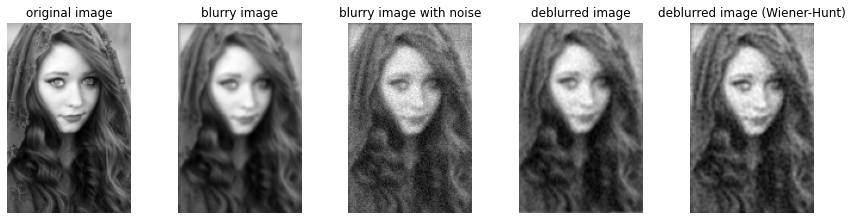

In [5]:
from matplotlib import image
import matplotlib.pyplot as plt
from skimage import color, transform, restoration

#circular convolution as is present with dft
def conv_circ(signal, ker):
    return np.real(np.fft.ifft2(np.fft.fft2(signal)*np.fft.fft2(ker)))

#import image
woman_image = image.imread('image_woman.jpg')
woman_image = transform.resize(color.rgb2gray(woman_image), (woman_image.shape[0] // 8, woman_image.shape[1] // 8),
                       anti_aliasing=True)

#introduce blurring
woman_image_blurred = conv_circ(woman_image, hTrueG)
#introduce noise
woman_image_blurred_with_noise = woman_image_blurred + np.random.normal(loc = 0, scale = sG, size = woman_image_blurred.shape)
#deblur own algorithm
deconvolved = conv_circ(woman_image_blurred_with_noise, g())
#deblur using wiener hunt algorithm
deconvolved_wiener_hunt, _ = restoration.unsupervised_wiener(woman_image_blurred_with_noise, hG)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 5),
                       sharex=True, sharey=True)
plt.gray()

ax[0].imshow(woman_image, vmin=woman_image.min(), vmax=woman_image.max())
ax[0].axis('off')
ax[0].set_title('original image')

ax[1].imshow(woman_image_blurred, vmin=woman_image_blurred.min(), vmax=woman_image_blurred.max())
ax[1].axis('off')
ax[1].set_title('blurry image')

ax[2].imshow(woman_image_blurred_with_noise, vmin=woman_image_blurred_with_noise.min(), vmax=woman_image_blurred_with_noise.max())
ax[2].axis('off')
ax[2].set_title('blurry image with noise')

ax[3].imshow(deconvolved, vmin=deconvolved.min(), vmax=deconvolved.max())
ax[3].axis('off')
ax[3].set_title('deblurred image')

ax[4].imshow(deconvolved_wiener_hunt, vmin=deconvolved_wiener_hunt.min(), vmax=deconvolved_wiener_hunt.max())
ax[4].axis('off')
ax[4].set_title('deblurred image (Wiener-Hunt)')

fig.tight_layout()

plt.show()

Noticing that the reconstruction quality highly depends on the amount of introduced noise you are first unsure if you really understood the content taught in DSSP or if you focused too much on "typical" exam questions being unable to adapt the knowledge to real world problems. However, by comparison with an unsupervised Wiener algorithm which estimates the noise automatically you realize that this is as good as it gets. Therefore you decide to only add very little noise. You take a leap of faith and send the photo to your friend.

You are sure that your friend will be properly pleased once you give her the coefficients of the inverse filter $G$. You are happy that you took this course and are curious what the future holds for you both.